# Определение стоимости автомобилей

### Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Задача проекта — построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импорт библиотек и данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px

from sklearn.metrics import mean_squared_error as mse_function
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

from lightgbm import LGBMRegressor
import optuna

from catboost import CatBoostRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from tqdm import tqdm

In [2]:
try:
    df = pd.read_csv('.../autos.csv')

except:
    df = pd.read_csv('.../autos.csv')


### Первичное изучение данных

Импортируем данные и изучим их.

In [3]:
df.head(5).T

,0,1,2,3,4
DateCrawled,2016-03-24 11:52:17,2016-03-24 10:58:45,2016-03-14 12:52:21,2016-03-17 16:54:04,2016-03-31 17:25:20
Price,480,18300,9800,1500,3600
VehicleType,NaN,coupe,suv,small,small
RegistrationYear,1993,2011,2004,2001,2008
Gearbox,manual,manual,auto,manual,manual
Power,0,190,163,75,69
Model,golf,NaN,grand,golf,fabia
Kilometer,150000,125000,125000,150000,90000
RegistrationMonth,0,5,8,6,7
FuelType,petrol,gasoline,gasoline,petrol,gasoline


**Признаки:**
* `DateCrawled`— дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак**
* `Price` — цена (евро)


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


* В датасете есть автомобили с нулевой ценой и мощностью и 1000 годом регистрации. Изучим и обработаем их позже.
* Признак `NumberOfPictures` удалим сразу, так как он пуст.

In [5]:
df = df.drop('NumberOfPictures', axis=1)

Проверим датасет на полные дубликаты и удалим их.

In [6]:
df.duplicated().sum()

4

In [7]:
df = df.drop_duplicates()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  PostalCode         354365 non-null  int64 
 14  LastSeen           354365 non-null  object
dtypes: int64(6), object(9)
memory usage: 43.3+ MB


В 5 признаках есть пропуски. Посмотрим на процент пропусков в каждом случае.

In [ ]:
missing_values = df.isna().mean() * 100
missing_columns = missing_values[missing_values > 0].sort_values(ascending=False).index.tolist()

trace = go.Bar(x=missing_columns, y=missing_values[missing_columns])

layout = go.Layout(
    title='Процент пропущенных значений в каждом признаке',
    xaxis=dict(title='Признак'),
    yaxis=dict(title='%')
)

fig = go.Figure(data=[trace], layout=layout)
fig.update_layout(width=800, height=400)
fig.show()

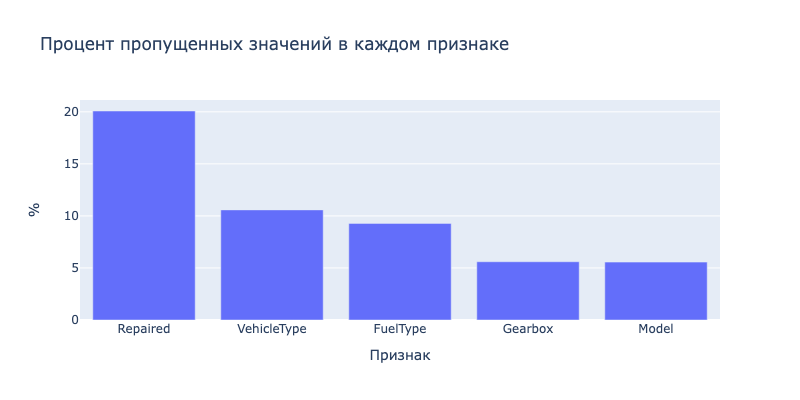


* Пропущенные значения есть в следующих столбцах: `Repaired`, `VehicleType`,`FuelType`, `Gearbox`, `Model`.

* Аномальные значения, как минимум, есть у признаков `RegistrationYear` и `Power`.

Изучим подробнее каждый признак, удалим аномалии и заполним пропуски. 

### Признак ["DateCrawled"] Дата скачивания анкеты из базы

Начнем по порядку с даты скачивания анкеты из базы. Сам по себе этот признак не будет иметь значения для предсказательной модели, но эта информация может помочь при заполнении пропусков в дальнейшем.

In [10]:
#переведем колонку в формат DateTime
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')

#посчитаем количетво целых дней, за которое у нас есть наблюдения
delta = df['DateCrawled'].max() - df['DateCrawled'].min()
print(delta.days)

33


In [11]:
# напишем фунцию для построения гистограмм
def histogram(column, bins=50, w=800, h=400, title=None):
    fig = px.histogram(df, x=column, nbins=bins).update_xaxes(categoryorder='total descending')
    fig.update_layout(width=w, height=h, title=title)
    fig.show()

In [ ]:
histogram("DateCrawled",delta.days, title="Дата скачивания анкет из базы")

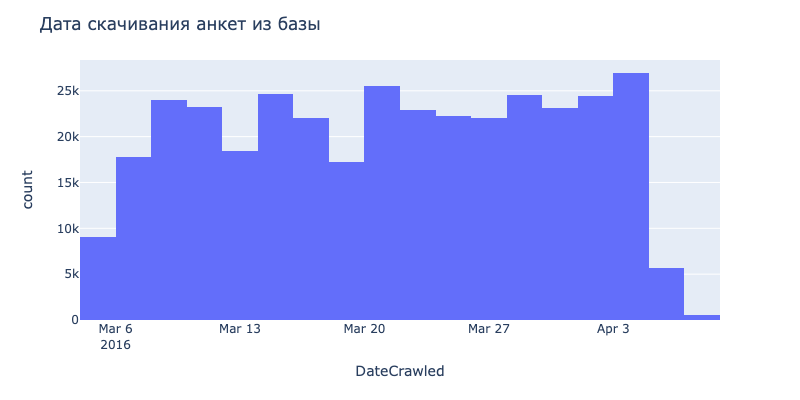

Данные выгружены с 5 марта по 7 апреля 2016 года. Данные выглядят корректно.

### Признак ["Price"] Цена

Изучим целевый признак 'Price'

In [ ]:
histogram('Price',50, title='Распределение цены')

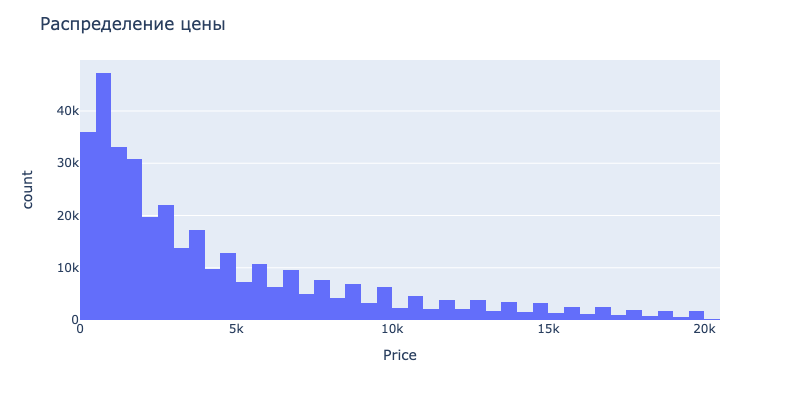

Посмотрим поближе значения цены до 1000 евро.

In [ ]:
column_slice = df.query('0 <= Price <= 1000')['Price']
histogram(column_slice, title='Распределение цен меньше 1000 евро')

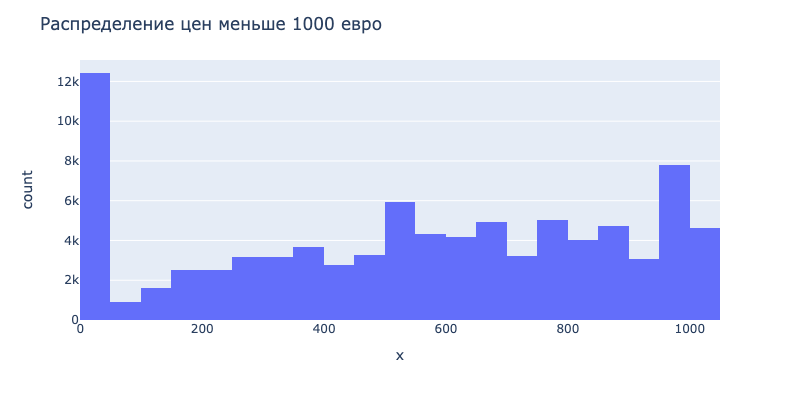

Посмотрим количетво машин со стоимостью 0.

In [15]:
df.query('Price == 0').shape[0]

10772

Удалим "бесплатные" машины из датасета.

In [16]:
df = df.query('Price != 0')

### Признак ['RegistrationYear'] Год регистрации

In [ ]:
histogram('RegistrationYear', title='Год регистрации автомобиля')

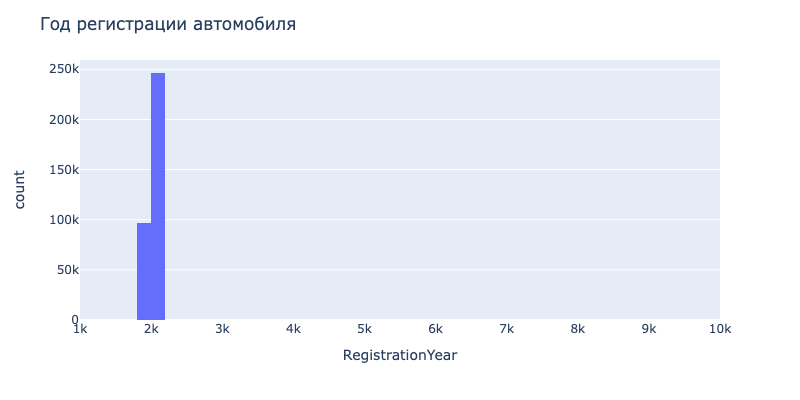

* В датафрейме есть машины, зарегистрированные задолго до изобретения автомобилей. Это явная ошибка, удалим эти значения.
* Также, как мы выяснили выше, анкеты были выгружены из системы с 5 марта по 7 апреля 2016 года. Соответственно, все анкеты старше 2016 года стоит удалить.

Посмотрим на количество значений после 2016 года.

In [18]:
(df['RegistrationYear'] > 2016).sum()

13779

Рассмотрим ближе первую половину 20 века.

In [ ]:
year_filter = df[(df['RegistrationYear'] < 1950) & (df['RegistrationYear'] > 1900)]['RegistrationYear']
histogram(year_filter, title='Годы регистрации автомобилей с 1900г до 1950г')

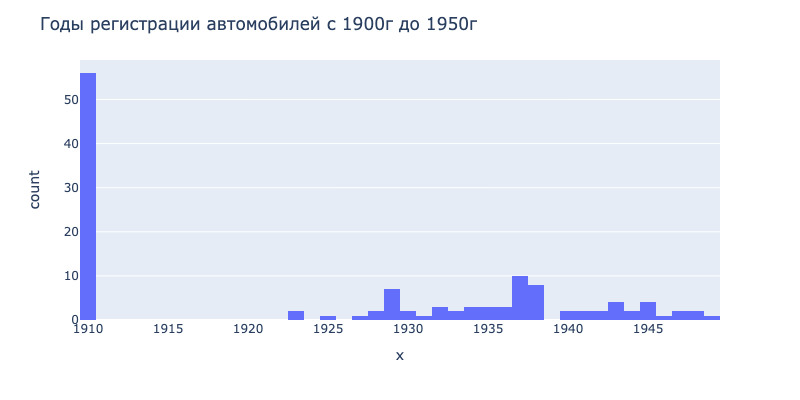

Видим, что в 1910 году было зарегестрировано 56 автомобилей. Будем считать выбросом все машины младше 1923 года.

In [20]:
df = df[(df['RegistrationYear'] < 2016) & (df['RegistrationYear'] > 1922)]

Проверим, что данные удалены.

In [21]:
(df['RegistrationYear'] > 2016).sum()

0

In [22]:
(df['RegistrationYear'] < 1922).sum()

0

Посмотрим как выглядит признак после удаления аномальных значений.

In [ ]:
histogram('RegistrationYear', 100, title='Количество автомобилей по году регистрации')

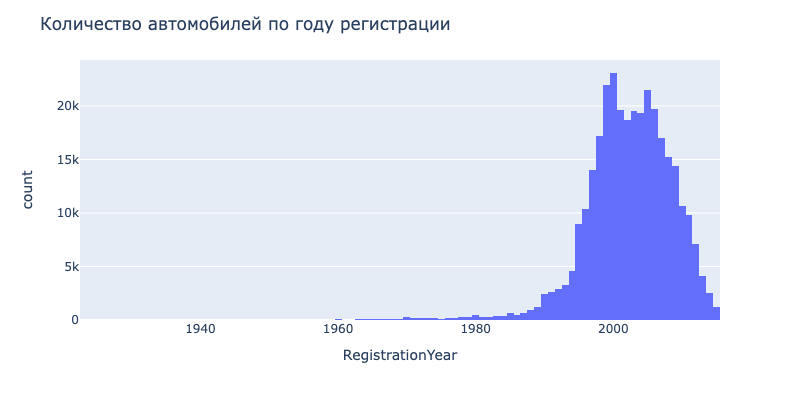

Посмотрим как связана цена автомобилей с годом регистрации.

In [ ]:
df_grouped = df.groupby('RegistrationYear')['Price'].median().reset_index()

fig = go.Figure(data=go.Scatter(x=df_grouped['RegistrationYear'], y=df_grouped['Price'], mode='lines+markers'))


fig.update_layout(title='Медианная цена автомобилей по году регистрации',
                   xaxis_title='Год регистрации',
                   yaxis_title='Средняя цена, евро')

fig.show()

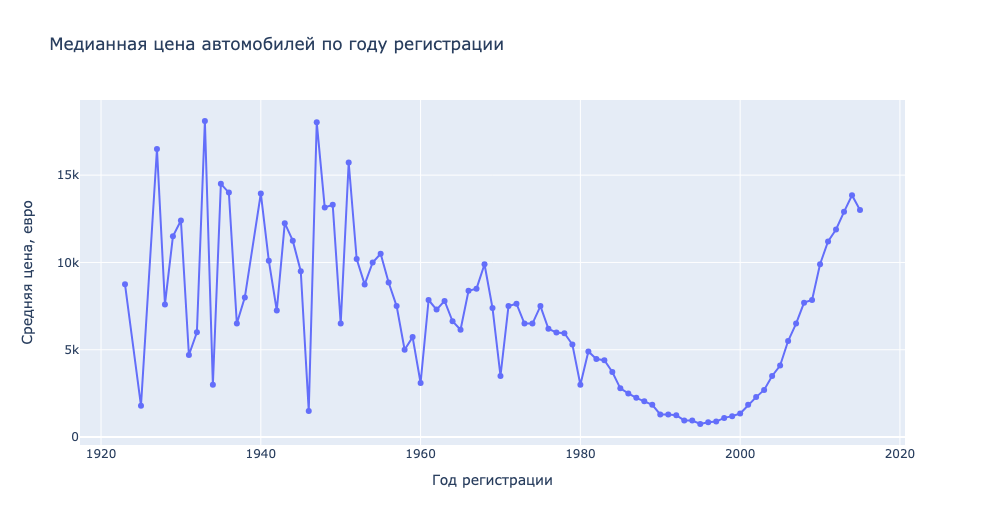

* Данные выглядят корректно: старые машины — это или дорогой раритет или машина, требующая дорогого востановления.
* Начиная с середины 90х чем новее машина, тем она дороже. 

### Признак ["Model"] Модель

Посмотрим 10 самых популярных марок автомобилей.

In [25]:
def top(column,number,t):
    count = df.groupby(column).size().reset_index(name='Count')
    top = count.nlargest(number, 'Count')
    fig = px.bar(top, x=column, y='Count', title=t)
    fig.show()   

In [ ]:
top('Model', 10, "Топ-10 популярных машин") 

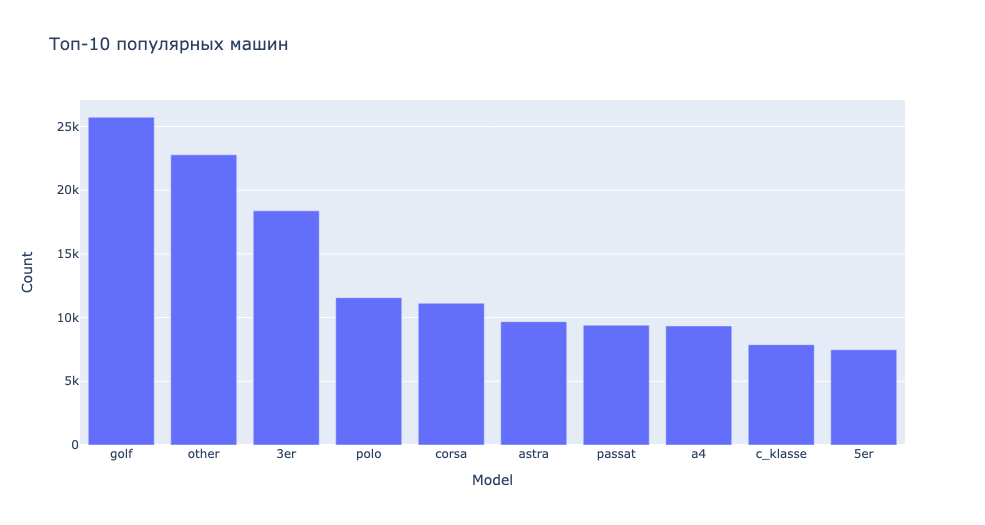

Но мы помним, что в данных есть пропуски. Удалим их с помощью следующего метода:
- Группируем данные по `Brand` и `RegistrationYear`.
- Заполняет пропущенные значения в `Model` с использованием моды для каждой группы.
- Если мода отсутствует, использует значение `other`.

In [27]:
df['Model'].isnull().sum()

14399

In [28]:
df['Model'] = df.groupby(['Brand', 'RegistrationYear'])['Model'].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "other")))


In [29]:
df['Model'].isnull().sum()

0

In [ ]:
top('Model', 10, "Топ-10 популярных машин после обработки пропусков") 

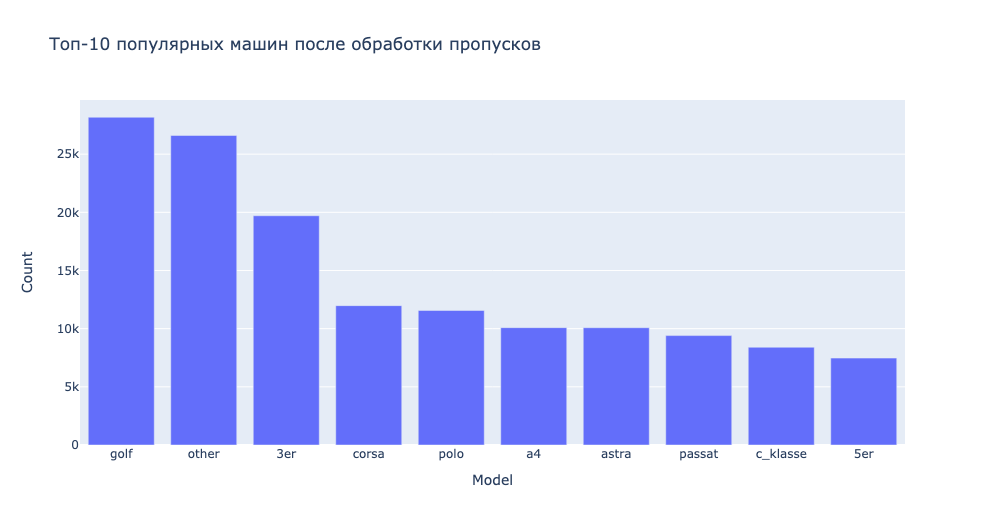

Посмотрим как связана цена автомобилей с моделью.

In [ ]:
df_median = df.groupby("Model")["Price"].mean().reset_index().sort_values(by='Price', ascending=False)

fig = px.bar(df_median, x="Model", y="Price", title="Медианная цена автомобилей по модели",
             labels={"Model": "Модель автомобиля", "Price": "Медианная цена, руб."})

fig.show()

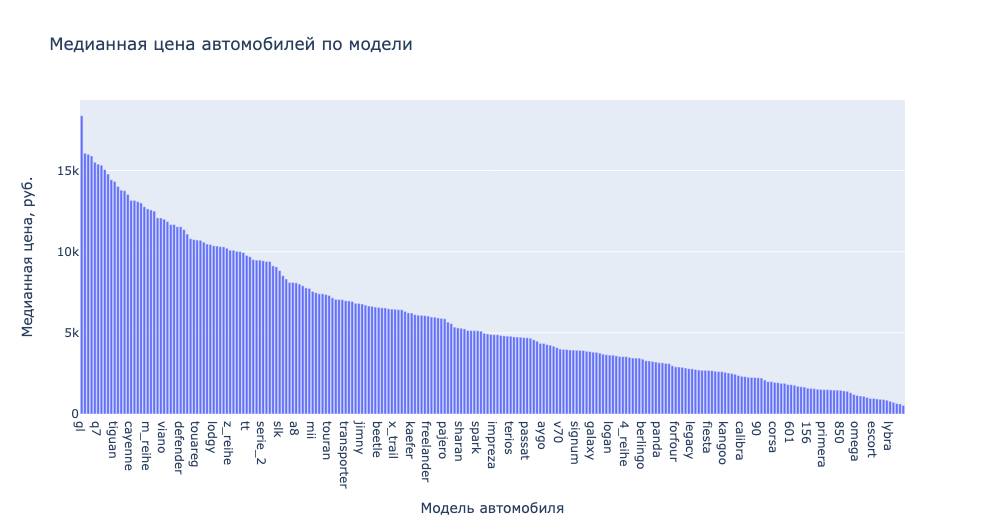

### Признак ['Power'] Мощность двигателя

In [ ]:
histogram("Power", title='Мощность двигателя')

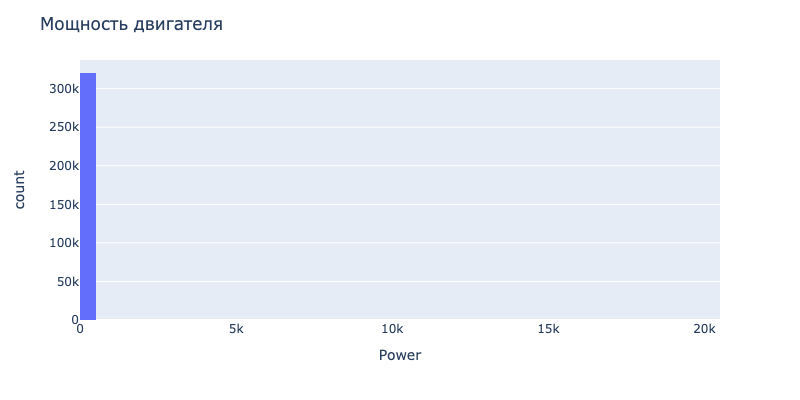

In [ ]:
fig = px.box(df, y="Power")
fig.show()

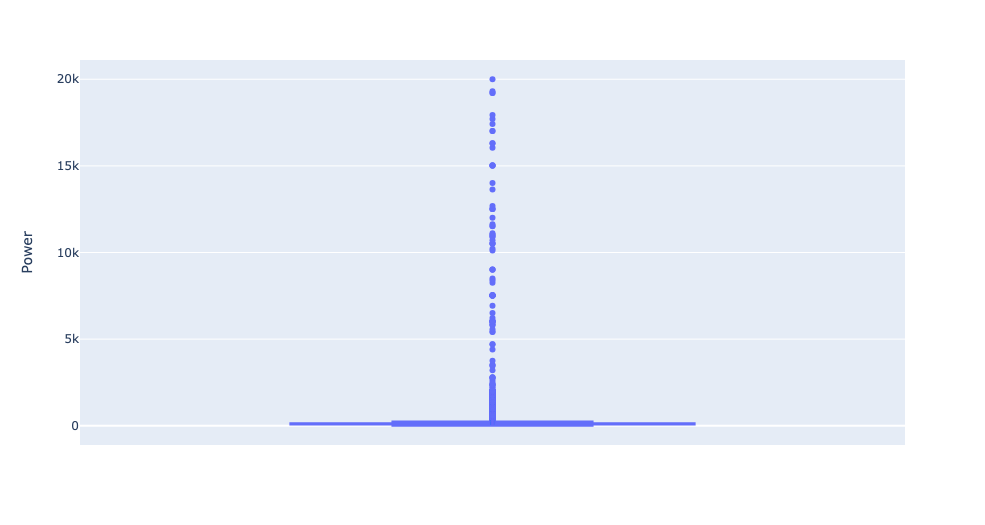

На гистограмме и боксплоте видим большое количество выбросов. Отсечем 0.1 высоких наблюдений.

In [ ]:
trashhold = np.percentile(df['Power'], 99.9)
filtered_power = df[df['Power'] <= trashhold]['Power']
histogram(filtered_power, title='99.9 процентиль мощности')

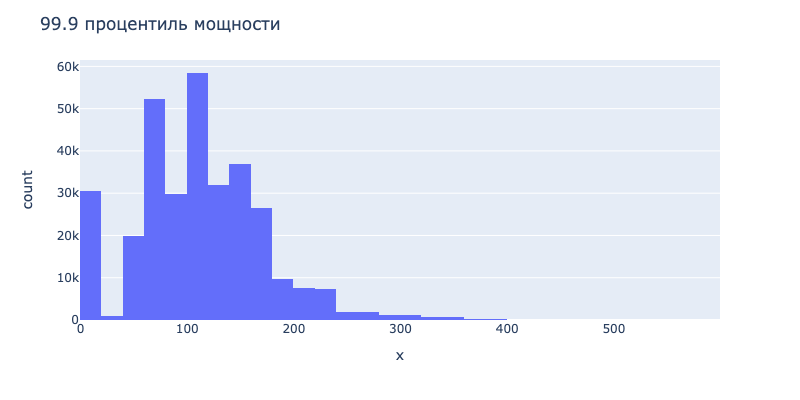

**Видим две аномалии**:
* Машины с аномально высокой мощность двигателя. Удалим из датасета автомобиле мощнее 400 лс
* Машины с 0 объемом двигателя.  Исследуем это подробнее.

Посмотрим на данные "супермощных" автомобилей.

In [35]:
df = df.query('Power < 400')

In [36]:
df.query('Power > 350')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
2262,2016-03-09 14:45:05,6500,convertible,1965,auto,360,other,150000,6,petrol,sonstige_autos,NaN,2016-03-09 00:00:00,67105,2016-04-06 08:46:00
2406,2016-03-08 17:44:18,13500,NaN,2006,auto,396,5er,150000,10,NaN,bmw,NaN,2016-03-08 00:00:00,49696,2016-03-27 11:17:40
2901,2016-03-30 11:41:34,12900,sedan,2006,auto,387,s_klasse,150000,7,petrol,mercedes_benz,no,2016-03-30 00:00:00,47443,2016-04-01 05:15:43
3245,2016-04-02 21:57:12,15500,sedan,2006,auto,387,s_klasse,150000,2,petrol,mercedes_benz,no,2016-04-02 00:00:00,59065,2016-04-06 23:45:57
4827,2016-03-26 14:44:10,15500,sedan,2004,auto,367,c_klasse,150000,6,petrol,mercedes_benz,no,2016-03-26 00:00:00,73312,2016-04-02 04:17:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349985,2016-04-04 00:55:36,14950,coupe,2007,auto,367,6er,150000,6,petrol,bmw,no,2016-04-04 00:00:00,22159,2016-04-06 09:16:39
350420,2016-03-25 16:57:36,19500,convertible,1997,auto,394,sl,150000,1,petrol,mercedes_benz,no,2016-03-25 00:00:00,25813,2016-04-06 22:45:01
352269,2016-03-28 17:41:20,6950,sedan,1998,auto,354,e_klasse,150000,6,petrol,mercedes_benz,no,2016-03-28 00:00:00,50354,2016-04-06 23:15:55
352295,2016-03-13 17:25:19,18500,wagon,2007,auto,386,e_klasse,150000,2,petrol,mercedes_benz,no,2016-03-13 00:00:00,61476,2016-04-06 18:15:29


Посмотрит на минимальную мощность двигателя.

In [37]:
df.groupby('Model')['Power'].median().sort_values()

Model
serie_1                 0.0
601                    26.0
samara                 30.0
kaefer                 34.0
move                   42.0
                      ...  
range_rover_evoque    296.0
6er                   300.0
cl                    306.0
cayenne               340.0
m_reihe               343.0
Name: Power, Length: 250, dtype: float64

* Хотя, мощность в 26 литров по современным меркам выглядит нереалистично, но при исследовании оказывается, что  `Трабант 601` действительно имел мощность 26 л.с, а `Volkswagen Kaefer` в разных модификациях — до 30 л.c.
* А вот средняя мощность samara (ВАЗ-2108) не может быть равна 28. 
* Поэтому во всех значениям мощности меньше 26 литров заменим их на медианную мощность модели.

Заменим значение мощности двигателей моделей "serie_1" и "samara"на верное.

In [38]:
df.loc[df['Model'] == 'serie_1', 'Power'] = 50
df.loc[df['Model'] == 'samara', 'Power'] = 65

In [39]:
df['Power'] = np.where(df['Power'] < 26, df.groupby('Model')['Power'].transform('median'), df['Power'])

In [ ]:
histogram('Power')

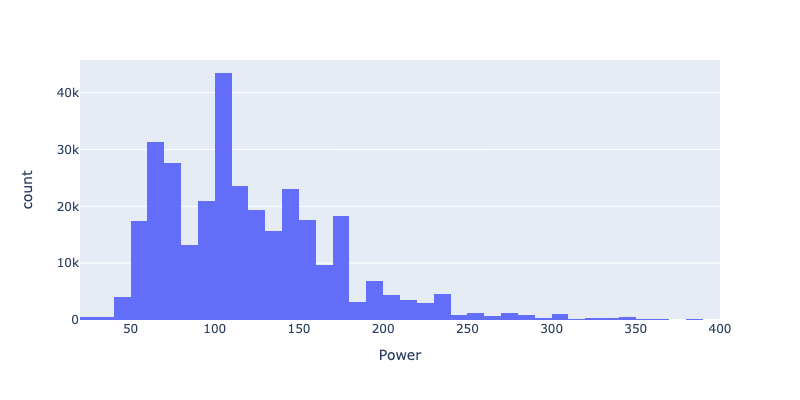

In [41]:
def price_impact(column, graph_name, unit):
    df_grouped = df.groupby(column)['Price'].median().reset_index()
    fig = go.Figure(data=go.Scatter(x=df_grouped[column], y=df_grouped['Price'], mode='lines+markers'))
    fig.update_layout(title=graph_name,
                   xaxis_title=unit,
                   yaxis_title='Средняя цена, евро')
    fig.show()

In [ ]:
price_impact('Power','Медианная цена автомобилей по мощности', 'Мощность, л.с.')

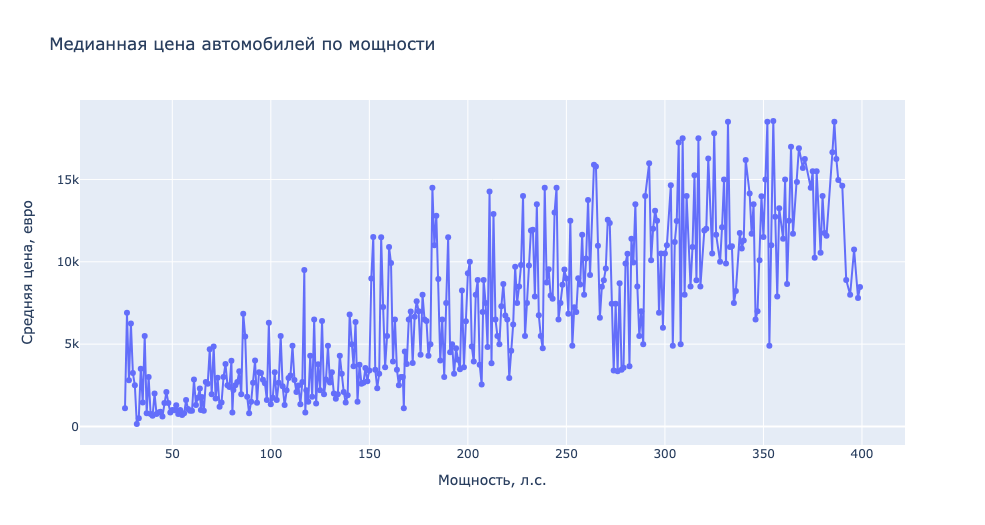

Чем выше мощность, тем выше цена. Всё логично.

### Признак ["VehicleType"] Тип кузова

In [ ]:
histogram(df['VehicleType'])

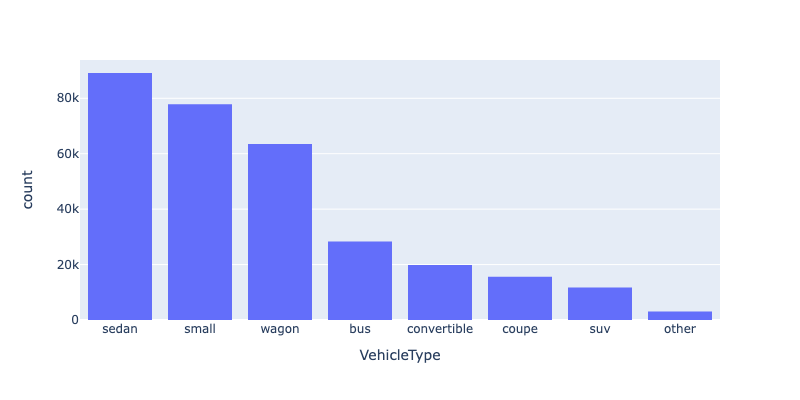

Заменим пропуски типа кузова на самое распространенное значение по модели.

In [44]:
df['VehicleType'] = df.groupby('Model')['VehicleType'].apply(lambda x: x.fillna(x.mode()[0]))

In [ ]:
histogram('VehicleType')

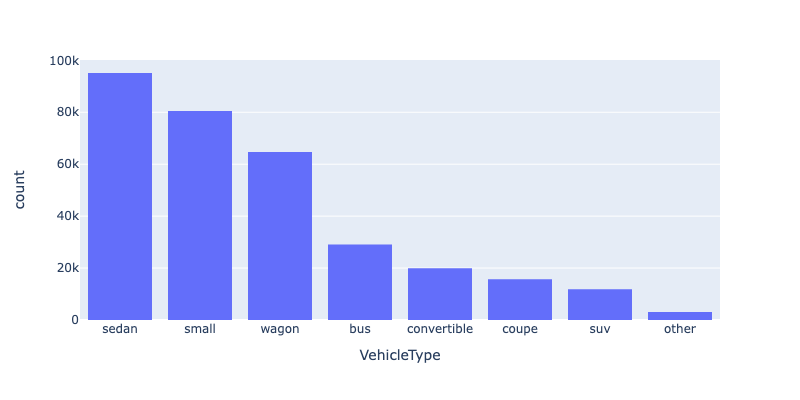

Посмотрим на связь цены и типа кузова.

In [ ]:
df_median = df.groupby("VehicleType")["Price"].mean().reset_index().sort_values(by='Price', ascending=False)


fig = px.bar(df_median, x="VehicleType", y="Price", title="Медианная цена автомобилей по типу кузова",
             labels={"VehicleType": "Тип кузова", "Price": "Медианная цена, руб."})

fig.show()

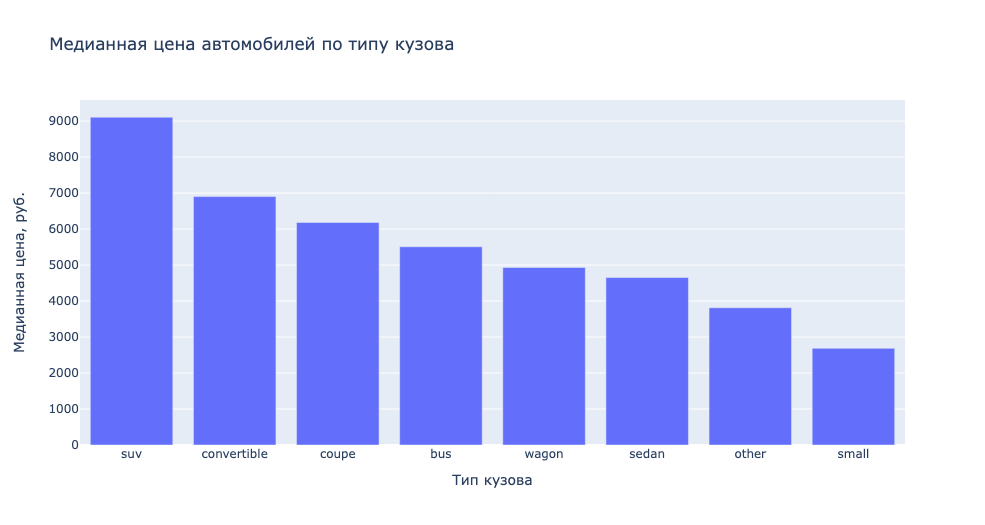

### Признак ["FuelType"] Тип топлива

In [ ]:
histogram('FuelType')

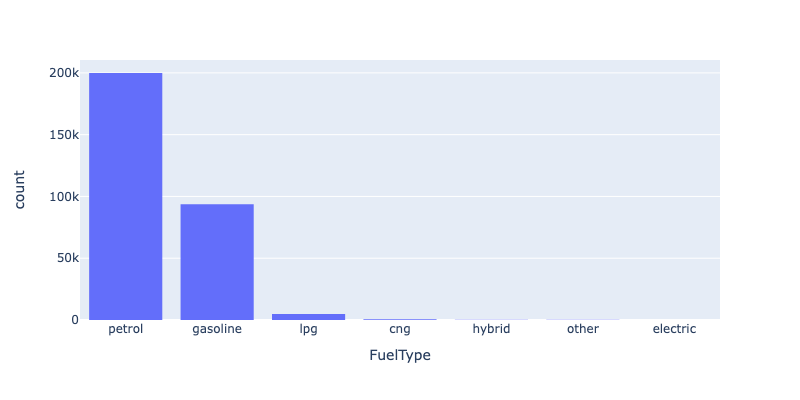

`gasoline` и `petrol` — это два разных термина, которые обозначают одно и то же топливо — бензин. Термин `gasoline` используется в США, в то время как `petrol` — в Великобритании и других странах. Так как наш датасет европейский, то заменим  на `petrol`.

In [48]:
df['FuelType'] = df['FuelType'].replace(['gasoline', 'petrol'], 'petrol')   

Заменим пропуски на моду.

In [49]:
df['FuelType'] = df.groupby('Model')['FuelType'].apply(lambda x: x.fillna(x.mode()[0]))

In [ ]:
histogram('FuelType')

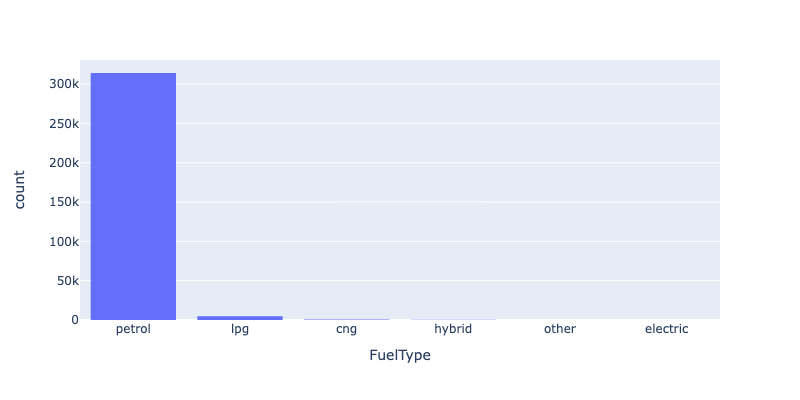

### Признак ["Gearbox"] Коробка передач

Заменим пропуски в коробке передач на моду модели.

In [51]:
df['Gearbox'] = df.groupby('Model')['Gearbox'].apply(lambda x: x.fillna(x.mode()[0]))

In [ ]:
histogram('Gearbox')

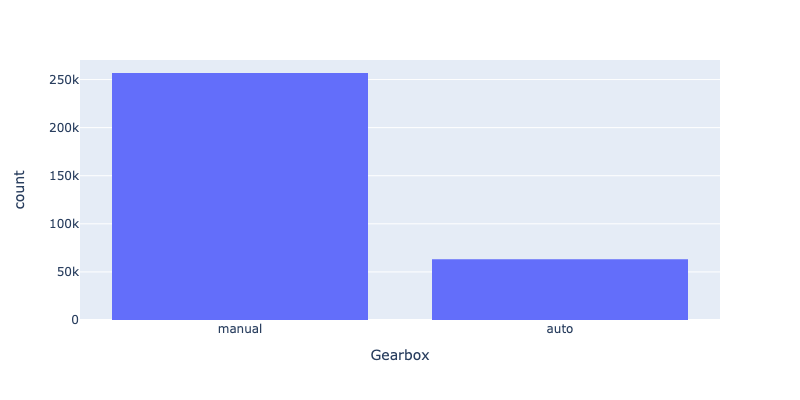

### Признак "Repaired" Была ли машина в ремонте

In [ ]:
histogram('Repaired')

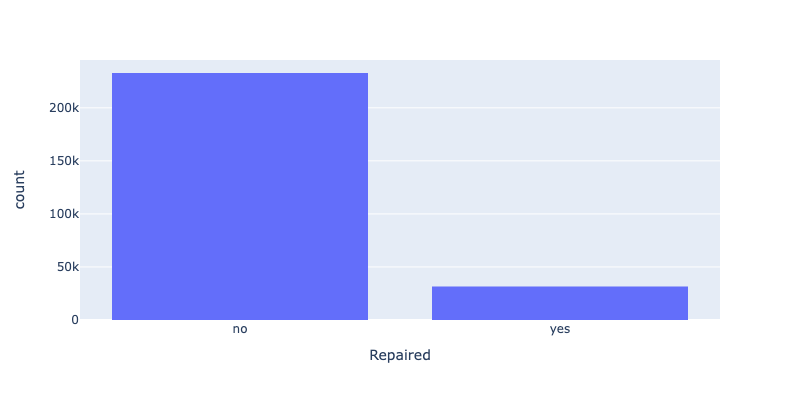

In [54]:
df['Repaired'].isnull().sum()

55544

Будем считать, что если в анкете не указано ремонтировалась ли машина, что она в ремонте не была.

In [55]:
df['Repaired'] = df['Repaired'].fillna('no')

In [56]:
df['Repaired'].isnull().sum()

0

In [ ]:
histogram('Repaired')

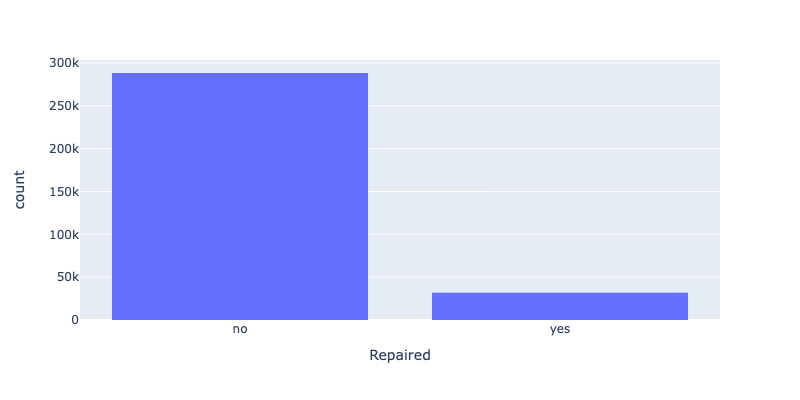

### Признак ["Brand"] Марка

In [ ]:
histogram('Brand')

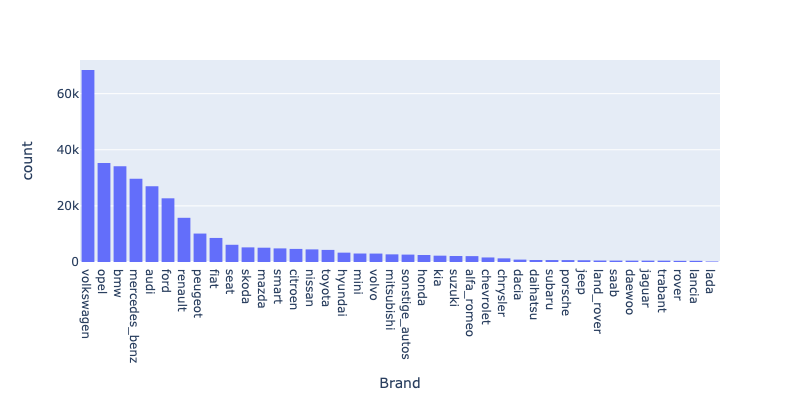

In [ ]:
df_median = df.groupby("Brand")["Price"].mean().reset_index().sort_values(by='Price', ascending=False)


fig = px.bar(df_median, x="Brand", y="Price", title="Медианная цена автомобилей по бренду",
             labels={"Brand": "Brand", "Price": "Медианная цена, руб."})

fig.show()

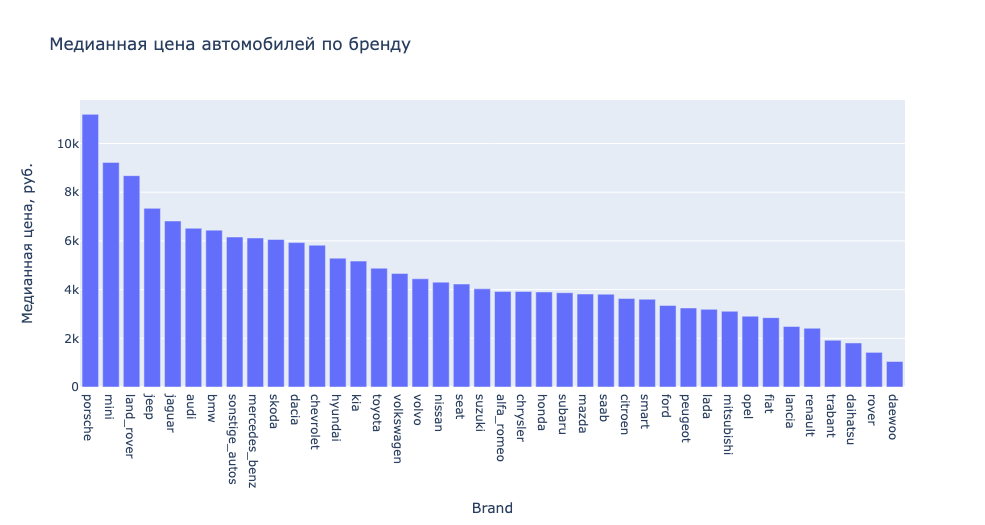

### Признак ["Kilometer"] Пробег

In [ ]:
histogram('Kilometer')

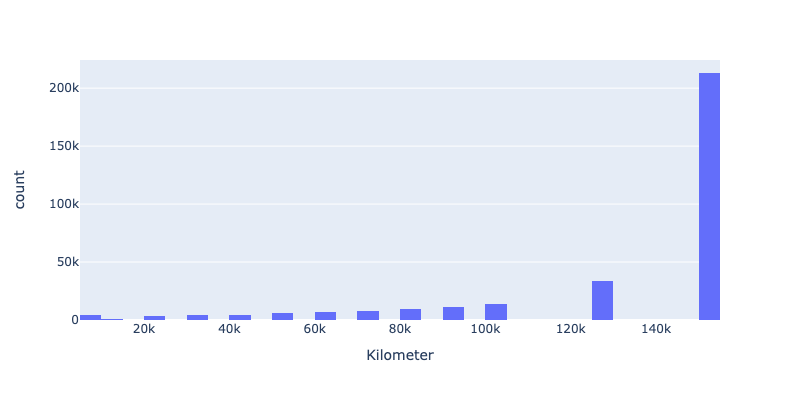

In [ ]:
price_impact('Kilometer','Медианная стоимость автомобиля в зависимости от пробега','Пробег, км')

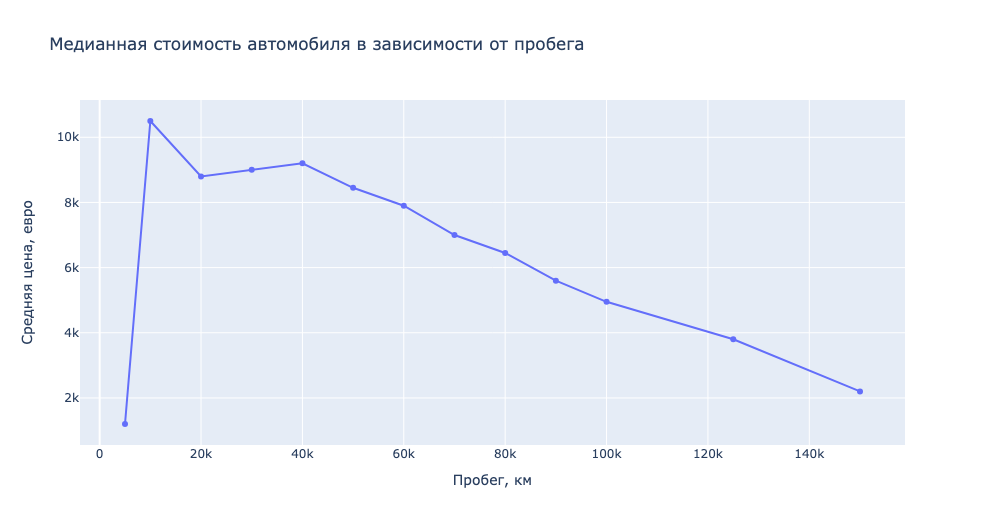

* Данные пробега были указаны дискретно, с шагом 10 000км до 100 000км и с шагом 25000 км после 100 000 км
* По всей видимости, все машины с пробегом "150 000 км +" отнесены в категорию 150 000км
* Связь медианной цены и пробега выглядит интуитивно — машины с маленьким пробегом стоят дороже. 

* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

### Признак ['DateCreated'] Дата создания анкеты

Приведем тип данных в столбце к `datetime`.

In [62]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')

# проверим тип данных столбца
print(df['DateCreated'].dtype)

datetime64[ns]


In [ ]:
histogram('DateCreated')

### Удаление лишних переменных

In [64]:
df = df.drop(['DateCrawled','RegistrationMonth','DateCreated','PostalCode','LastSeen'], axis=1)

In [65]:
df.shape

(320053, 10)

**Промежуточный вывод**:
* Мы провели исследовательский анализ данных. Исследовали данные, удалили дубликаты, обработали аномальные значения и пропуски. В результате предобработке датасет стал меньше на 33628 строк, что ~ 10% данных.
- Удалены автомобили с нулевой ценой.
- Удалены аномалии по годам регистрации автомобилей: анкеты старше 2016 года и автомобили, зарегистрированные до изобретения автомобилей.
- Исправлены аномалии в мощности автомобилей: заменены пропуски медианой по модели для машин с мощностью более 350 лс и меньше 26 лс.
- Заполнены пропуски значений в типе кузова медианными значениями модели.
- Объединены категории топлива (`gasoline` и `petrol`) и заполнены пропуски модой модели.
- Заполнены пропуски в значениях коробки передач модой.
- Удалены нерелевантные переменные для машинного обучения: `DateCrawled`, `RegistrationMonth`, `NumberOfPictures`, `DateCreated`, `PostalCode`, `LastSeen`.


## Обучение моделей

В нашем проекте мы обучим и протестируем 4 модели:
- Модель линейной регрессии
- XGBRegressor 
- LGBMRegressor
- CatBoostRegressor 

У каждой модели замерим 3 критерия: качество предсказаний, время обучения и время предсказания.

При построении модели будем использовать следующие признаки:

**Категориальные**: 
    
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Model` — модель автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет

**Количественные признаки**
- `Power` — мощность (л. с.)
- `Kilometer` — пробег (км)

**Целевой признак**
- `Price` — цена

### Модель линейной регрессии

Обучим модель линейной регрессии.

In [66]:
df_lr = df.copy()

Разделим выборки на обучающую, валидационную и тестовую  в пропорции 80/10/10. Выделим признаки (features) и целевую переменную (target)

In [67]:
train_data, test_valid_data = train_test_split(df_lr, shuffle=False, test_size=0.2, random_state=42)
valid_data, test_data = train_test_split(test_valid_data, shuffle=False, test_size=0.5, random_state=42)


x_train, y_train = train_data.drop('Price', axis=1), train_data['Price']
x_valid, y_valid = valid_data.drop('Price', axis=1), valid_data['Price']
x_test, y_test = test_data.drop('Price', axis=1), test_data['Price']

Закодируем категориальные переменные с помощью `onehot_encoder`. Преобразуем каждый датасет в отдельности.

In [68]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
onehot_encoder.fit(x_train[cat_columns])

# Функция для преобразования данных с использованием OneHotEncoder
def transform_with_onehot(df, encoder, cat_columns):
    encoded_data = encoder.transform(df[cat_columns])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cat_columns), index=df.index)
    return pd.concat([df.drop(cat_columns, axis=1), encoded_df], axis=1)


x_train = transform_with_onehot(x_train, onehot_encoder, cat_columns)
x_valid = transform_with_onehot(x_valid, onehot_encoder, cat_columns)
x_test = transform_with_onehot(x_test, onehot_encoder, cat_columns)


Выполним масштабирование количественных признаков.

In [69]:
scaler = StandardScaler()

x_train[['Power', 'Kilometer', 'RegistrationYear']] = scaler.fit_transform(x_train[['Power', 'Kilometer', 'RegistrationYear']])
x_valid[['Power', 'Kilometer', 'RegistrationYear']] = scaler.transform(x_valid[['Power', 'Kilometer', 'RegistrationYear']])
x_test[['Power', 'Kilometer', 'RegistrationYear']] = scaler.transform(x_test[['Power', 'Kilometer', 'RegistrationYear']])

Обучим модель линейной регресии.

In [70]:
%%time

model = LinearRegression()
model.fit(x_train, y_train)

CPU times: user 9.73 s, sys: 2.83 s, total: 12.6 s
Wall time: 3.2 s


LinearRegression()

Cделаем предсказание и оценим его время.

In [71]:
%%time
y_pred = model.predict(x_valid)

CPU times: user 225 ms, sys: 128 ms, total: 353 ms
Wall time: 59.1 ms


In [72]:
mse = mse_function(y_valid, y_pred)
print(f"RMSE на валидационной выборке: {np.sqrt(mse)}")

RMSE на валидационной выборке: 2698.2740632800187


### XGboost 

Обучим модель XGboost.

In [73]:
df_xg = df.copy()

In [74]:
x = df_xg.drop('Price', axis=1)
y = df_xg['Price']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

Кодируем переменные с LabelEncoder.

In [75]:
label_encoder = LabelEncoder()
for column in x_train.columns:
    if x_train[column].dtype == 'object':
        label_encoder.fit(pd.concat([x_train[column], x_valid[column], x_test[column]]))
        x_train[column] = label_encoder.transform(x_train[column])
        x_valid[column] = label_encoder.transform(x_valid[column])
        x_test[column] = label_encoder.transform(x_test[column])

In [76]:
scaler = StandardScaler()
x_train[['Power', 'Kilometer', 'RegistrationYear']] = scaler.fit_transform(x_train[['Power', 'Kilometer', 'RegistrationYear']])
x_valid[['Power', 'Kilometer', 'RegistrationYear']] = scaler.transform(x_valid[['Power', 'Kilometer', 'RegistrationYear']])
x_test[['Power', 'Kilometer', 'RegistrationYear']] = scaler.transform(x_test[['Power', 'Kilometer', 'RegistrationYear']])

Обучим модель без оптимизации гиперпараметров

In [77]:
%%time
xgb_model = xgb.XGBRegressor()
xgb_model.fit(x_train, y_train)

CPU times: user 1min 2s, sys: 11.3 s, total: 1min 14s
Wall time: 10.1 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [78]:
%%time
# Получаем предсказания на тестовых данных
y_pred = xgb_model.predict(x_valid)

CPU times: user 106 ms, sys: 14.4 ms, total: 120 ms
Wall time: 20.5 ms


In [79]:
%%time
# Считаем RMSE на тестовых данных
rmse = mse_function(y_valid, y_pred, squared=False)
print(f'RMSE на валидационной выборке: {rmse:.3f}')

RMSE на валидационной выборке: 1665.089
CPU times: user 4.4 ms, sys: 4.82 ms, total: 9.22 ms
Wall time: 1.63 ms


Подберем гиперпараметры с помощью Optuna, ограничим подрор 10 иттерациями.

In [80]:
%%time
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'random_state': 1967
    }
    
    model = xgb.XGBRegressor(**param)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    rmse = mse_function(y_test, y_pred, squared=False)
    
    return rmse


study = optuna.create_study(direction='minimize')

with tqdm(total=10) as pbar:
    for i in range(10):
        pbar.update(1)
        study.optimize(objective, n_trials=1)
        
best_params = study.best_params
print("Best params:", best_params)

xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(x_train, y_train)

[I 2023-06-28 15:48:20,589] A new study created in memory with name: no-name-8f5d2789-d6b4-40c1-93e9-0ee4a4dd9a64
100%|███████████████████████████████████████████| 10/10 [01:29<00:00,  8.97s/it]


Best params: {'n_estimators': 54, 'max_depth': 13}
CPU times: user 10min 44s, sys: 1min 12s, total: 11min 56s
Wall time: 1min 43s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=54, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [81]:
%%time
y_pred = xgb_model.predict(x_valid)

CPU times: user 185 ms, sys: 9.8 ms, total: 195 ms
Wall time: 44 ms


In [82]:
%%time
rmse = mse_function(y_valid, y_pred, squared=False)
print(f'RMSE на валидационной выборке: {rmse:.3f}')

RMSE на валидационной выборке: 1602.595
CPU times: user 2.39 ms, sys: 1.35 ms, total: 3.74 ms
Wall time: 3.5 ms


### LGBM

Обучим модель LGBM.

In [83]:
df_lgbm = df.copy()

In [84]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

for col in cat_columns:
    df_lgbm[col] = df_lgbm[col].astype('category')

# Разобъём выборку на тренировочную, валидационную и тестовую
x = df_lgbm.drop('Price', axis=1)
y = df_lgbm['Price']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)


Обучим LGBM без оптимизации.

In [85]:
%%time
model = LGBMRegressor()
model.fit(x_train, y_train)

CPU times: user 3.67 s, sys: 381 ms, total: 4.05 s
Wall time: 589 ms


LGBMRegressor()

In [86]:
%%time
# Получаем предсказания на тестовых данных
y_pred = model.predict(x_valid)

CPU times: user 314 ms, sys: 12.9 ms, total: 327 ms
Wall time: 44.6 ms


In [87]:
# Считаем RMSE на тестовых данных
rmse = mse_function(y_valid, y_pred, squared=False)
print(f'RMSE на валидационной выборке: {rmse:.3f}')

RMSE на валидационной выборке: 1659.633


Оптимизируем гиперпараметры с Optuna

In [88]:
%%time

def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'random_state': 1967
    }
    model = LGBMRegressor(**param)
    score = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return np.sqrt(-score.mean())


study = optuna.create_study(direction='minimize')


with tqdm(total=5) as pbar:
    for i in range(5):
        pbar.update(1)
        study.optimize(objective, n_trials=1)


# Выводем лучшие параметры
print("Best trial:")
trial = study.best_trial
print("  Value: {:.3f}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Обучим модель с лучшими гиперпараметрами на всей обучающей выборке
best_params = trial.params
lgbm_optimized = LGBMRegressor(**best_params)
lgbm_optimized.fit(x_train, y_train)

[I 2023-06-28 15:50:05,083] A new study created in memory with name: no-name-e2d4c271-ebe9-45b0-9343-fbef020c8ef5
100%|█████████████████████████████████████████████| 5/5 [00:20<00:00,  4.08s/it]


Best trial:
  Value: 1617.926
  Params: 
    num_leaves: 99
    max_depth: 14
CPU times: user 2min 14s, sys: 16.4 s, total: 2min 31s
Wall time: 22 s


LGBMRegressor(max_depth=14, num_leaves=99)

In [89]:
%%time
# Оценка на тестовой выборке
y_pred_optimized = lgbm_optimized.predict(x_valid)


CPU times: user 478 ms, sys: 26.2 ms, total: 505 ms
Wall time: 74.1 ms


In [90]:
rmse_optimized = np.sqrt(mse_function(y_valid, y_pred_optimized))
print("Оптимизированный RMSE: {:.3f}".format(rmse_optimized))

Оптимизированный RMSE: 1598.383


### Cat Boost

Обучим модель Cat Boost без оптимизации гиперпараметров.

In [91]:
%%time
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.1,
                          depth=6,
                          loss_function='RMSE',
                          random_state=1967,
                          verbose=False,
                          cat_features=cat_columns)

model.fit(x_train, y_train)

CPU times: user 3min 57s, sys: 10.7 s, total: 4min 8s
Wall time: 42.2 s


In [92]:
%%time
y_pred = model.predict(x_valid)

CPU times: user 223 ms, sys: 14 ms, total: 237 ms
Wall time: 68.6 ms


In [93]:
rmse = np.sqrt(mse_function(y_valid,y_pred))
print(f"RMSE: {rmse:.3f}")

RMSE: 1656.748


Оптимизируем CatBoost, ограничимся 2 иттерациями, иначе модель будут обучаться долго.

In [94]:
%%time


def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
    }

    model = CatBoostRegressor(loss_function='RMSE',random_state=1967,verbose=False,cat_features=cat_columns,**params)

    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    rmse = np.sqrt(mse_function(y_test, y_pred))

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)

best_params = study.best_params
print("Best params:", best_params)

best_model = CatBoostRegressor(
    loss_function='RMSE',
    random_state=1967,
    verbose=False,
    cat_features=cat_columns,
    **best_params
)

best_model.fit(x_train, y_train)

[I 2023-06-28 15:51:09,520] A new study created in memory with name: no-name-4d7fc70a-c8dc-4628-9137-ede2c9619bec
[I 2023-06-28 15:51:59,369] Trial 0 finished with value: 1623.0620588762956 and parameters: {'iterations': 830, 'depth': 8, 'border_count': 238}. Best is trial 0 with value: 1623.0620588762956.
[I 2023-06-28 15:52:22,692] Trial 1 finished with value: 1715.7966754765648 and parameters: {'iterations': 848, 'depth': 4, 'border_count': 35}. Best is trial 0 with value: 1623.0620588762956.


Best params: {'iterations': 830, 'depth': 8, 'border_count': 238}
CPU times: user 11min 10s, sys: 29.2 s, total: 11min 39s
Wall time: 1min 59s


In [95]:
%%time
y_pred = best_model.predict(x_valid)

CPU times: user 265 ms, sys: 8.39 ms, total: 274 ms
Wall time: 67.1 ms


In [96]:
rmse = np.sqrt(mse_function(y_valid, y_pred))
print(f"RMSE (optimized): {rmse:.3f}")

RMSE (optimized): 1617.192


**Промежуточный вывод**:
- Обучили 4 модели: `LinearRegression`,  `XGboost`, `LGBM` и `Cat Boost`
- Измерили RMSE, время обучения и время предсказания для каждой модели валидационной выборке.
- Можем приступить к сравнению моделей.

## Анализ моделей

In [97]:
res = {'Model': ['LinearRegression', 'XGBoost', 'XGBoost + Optuna', 'LGBM', 'LGBM + Optuna', 'CatBoost', 'CatBoost + Optuna'],
        'RMSE': [2698, 1665, 1584, 1660, 1606, 1657, 1586],
        'Studying time': ['3.31 s', '9.94 s', '1min 26s', '629 ms', '19.5 s', '41.7 s', '3min 28s'],
        'Prediction time': ['77.5 ms', '25 ms', '45.5 ms', '53.1 ms', '73.7 ms', '62.7 ms', '217 ms']}


results = pd.DataFrame(res)
results

,Model,RMSE,Studying time,Prediction time
0,LinearRegression,2698,3.31 s,77.5 ms
1,XGBoost,1665,9.94 s,25 ms
2,XGBoost + Optuna,1584,1min 26s,45.5 ms
3,LGBM,1660,629 ms,53.1 ms
4,LGBM + Optuna,1606,19.5 s,73.7 ms
5,CatBoost,1657,41.7 s,62.7 ms
6,CatBoost + Optuna,1586,3min 28s,217 ms


In [98]:
sorted_results = results.sort_values(by='RMSE', ascending=True)
sorted_results

,Model,RMSE,Studying time,Prediction time
2,XGBoost + Optuna,1584,1min 26s,45.5 ms
6,CatBoost + Optuna,1586,3min 28s,217 ms
4,LGBM + Optuna,1606,19.5 s,73.7 ms
5,CatBoost,1657,41.7 s,62.7 ms
3,LGBM,1660,629 ms,53.1 ms
1,XGBoost,1665,9.94 s,25 ms
0,LinearRegression,2698,3.31 s,77.5 ms


**Выводы**:

Проанализруем модели по 3 критериям и выберем оптимальную.


- **Качество предсказания**: лучшие результаты показывают модели XGBoost (RMSE = 1584) и CatBoost(RMSE = 1586) и LGBM(RMSE = 1606), оптимизированные с помощью Optuna.

- **Время обучения**: LGBM (629 мс) обучается быстрее всех остальных моделей. Но стоит учесть, что LGBM + Optuna обучается всего за 19.5 секунды и имеет лучшее качество предсказаний.

- **Время предсказания**: XGBoost (25 мс) и XGBoost + Optuna (45.5 мс) показывают самое быстрое время предсказания. Однако, стоит заметить, что все модели не сильно отличаются по скорости предсказанйи.

**Общий вывод**: Так как нам нужен оптимальный баланс между качеством предсказания, временем обучения и временем предсказания, то LGBM + Optuna является лучшим выбором. 

## Тестирование лучшей модели

In [99]:
x_train_valid = pd.concat([x_train, x_valid])
y_train_valid = pd.concat([y_train, y_valid])

In [100]:
%%time

def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'random_state': 1967
    }
    model = LGBMRegressor(**param)
    score = cross_val_score(model, x_train_valid, y_train_valid, cv=5, scoring='neg_mean_squared_error')
    return np.sqrt(-score.mean())



study = optuna.create_study(direction='minimize')


with tqdm(total=5) as pbar:
    for i in range(5):
        pbar.update(1)
        study.optimize(objective, n_trials=1)


# Выводем лучшие параметры
print("Best trial:")
trial = study.best_trial
print("  Value: {:.3f}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Обучим модель с лучшими гиперпараметрами на всей обучающей выборке
best_params = trial.params
lgbm_optimized = LGBMRegressor(**best_params)
lgbm_optimized.fit(x_train, y_train)

[I 2023-06-28 15:53:09,177] A new study created in memory with name: no-name-33e2de63-4783-419c-bfec-b0b97dd7a2c0
100%|█████████████████████████████████████████████| 5/5 [00:24<00:00,  4.84s/it]


Best trial:
  Value: 1613.087
  Params: 
    num_leaves: 99
    max_depth: 12
CPU times: user 2min 42s, sys: 16.1 s, total: 2min 58s
Wall time: 25.1 s


LGBMRegressor(max_depth=12, num_leaves=99)

In [101]:
%%time
# Оценка на тестовой выборке
y_pred_optimized = lgbm_optimized.predict(x_test)

CPU times: user 471 ms, sys: 23.1 ms, total: 494 ms
Wall time: 79.8 ms


In [102]:
rmse_optimized = np.sqrt(mse_function(y_test, y_pred_optimized))
print("Оптимизированный RMSE: {:.3f}".format(rmse_optimized))

Оптимизированный RMSE: 1612.948


**Вывод**:
- Лучшей моделью по точности, скорости обучения и предсказания оказалась модель LGBM.
- На тестовой выборке она показала следующие результаты: `RMSE`: 1614, `скорость обучения` 21.5 s, `скорость предсказания` 78.9 ms. Что говорит о том, что модель работает быстро и достаточно точно, а так же то, что она не переобучилась на тренировочных данных.

### Финальный вывод:

В рамках проекта по определению стоимости автомобилей был поведен исследовательский анализ данных и построены модели для предсказания стоимости. 

- Провели предобработку данных, включая удаление дубликатов, обработку аномалий и заполнение пропусков. В результате предобработки датасет уменьшился на 10% и стал готов для анализа.

- Были обучены 4 модели: `линейная регрессия`, `XGBoost`, `LGBM` и `CatBoost`. Каждая модель была оценена по нескольким критериям, включая качество предсказания, время обучения и время предсказания.

- По результатам сравнения моделей, лучшей моделью оказалась LGBMRegressor. Она продемонстрировала высокую точность предсказания, быструю скорость обучения и низкое время предсказания. На тестовой выборке модель LGBMRegressor показала RMSE равное 1614, время обучения 21.5 секунд и время предсказания 78.9 миллисекунд.

Таким образом, проект успешно достиг поставленных целей, предоставив модель, которая быстро и точно предсказывает стоимость автомобилей.